# Final Model

In [3]:
!git clone https://github.com/rslim087a/track.git

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 39.90 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [4]:
import cv2
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import pandas as pd
import random
import os
import keras
import ntpath
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [5]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

# Visualization

---

Steering angles

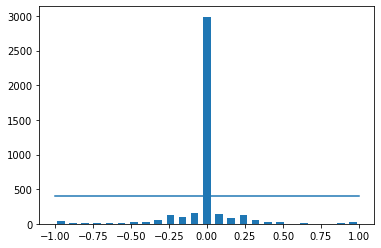

In [7]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4053
removed: 2590
remaining: 1463


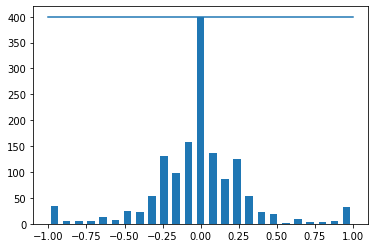

In [8]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist,_ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=.2, random_state=6)

Text(0.5, 1.0, 'Valid Set')

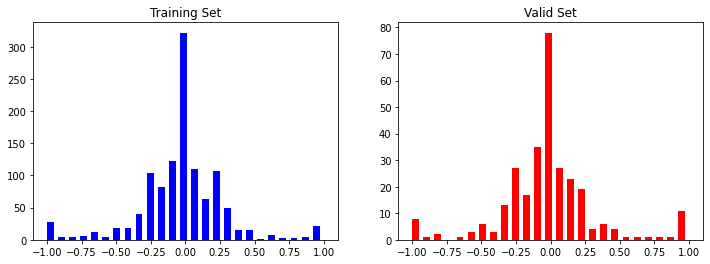

In [11]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Valid Set')

In [12]:
from imgaug import augmenters as iaa

def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

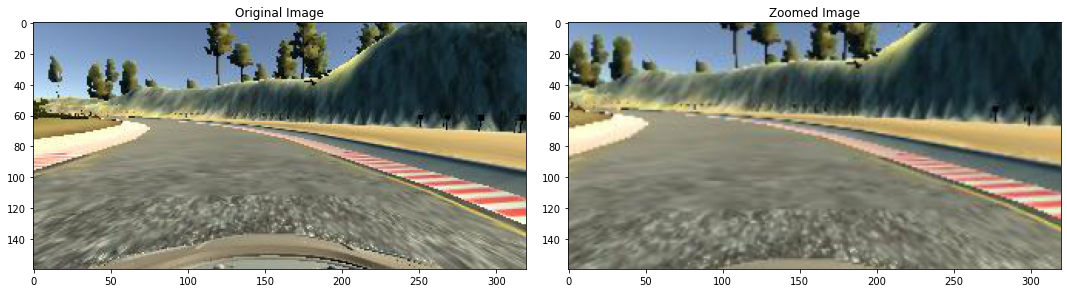

In [13]:
image = image_paths[0]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed Image')

In [14]:
def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-.1, .1), 'y': (-.1, .1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

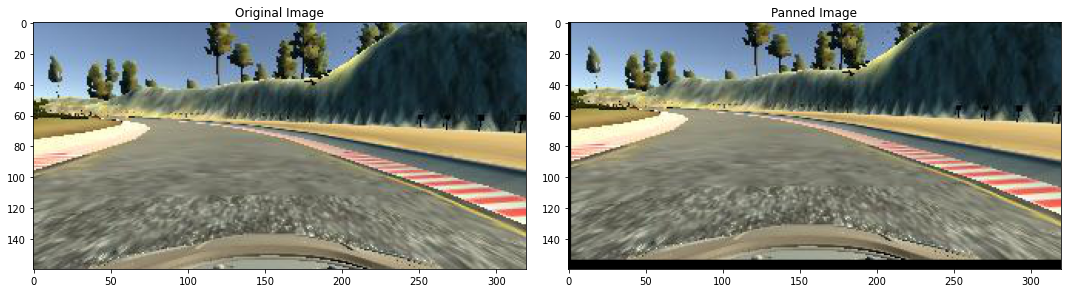

In [15]:
image = image_paths[0]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')

In [16]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

In [17]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Original Image with Random Brightness')

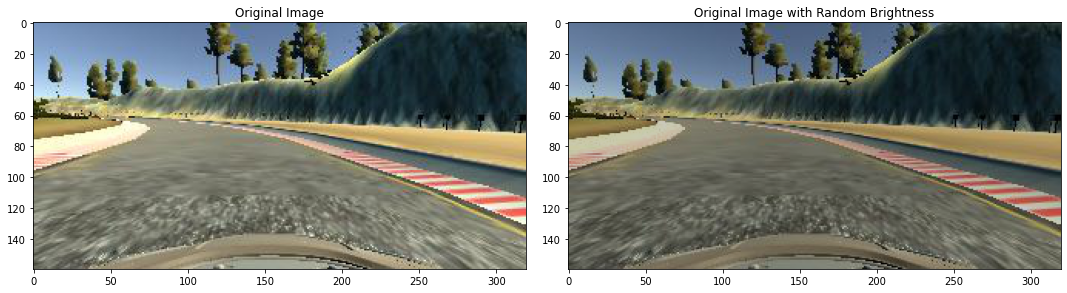

In [18]:
image = image_paths[0]
original_image = mpimg.imread(image)
random_image = img_random_brightness(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

axes[1].imshow(random_image)
axes[1].set_title('Original Image with Random Brightness')

Text(0.5, 1.0, 'Flipped Image')

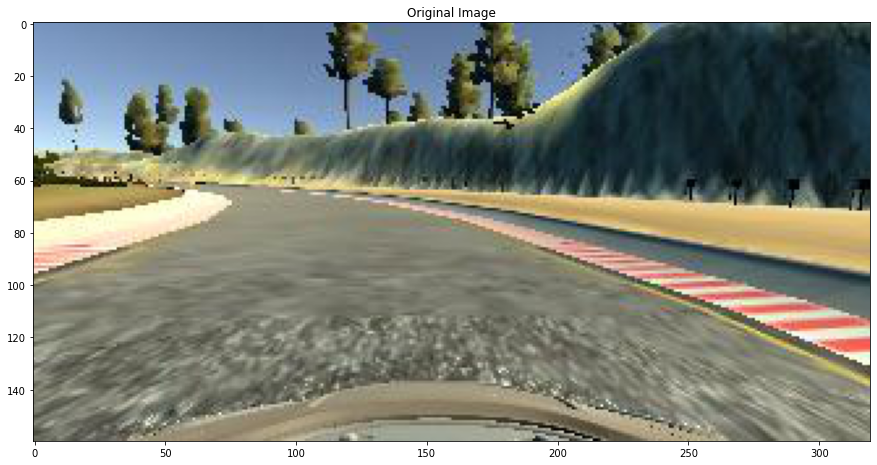

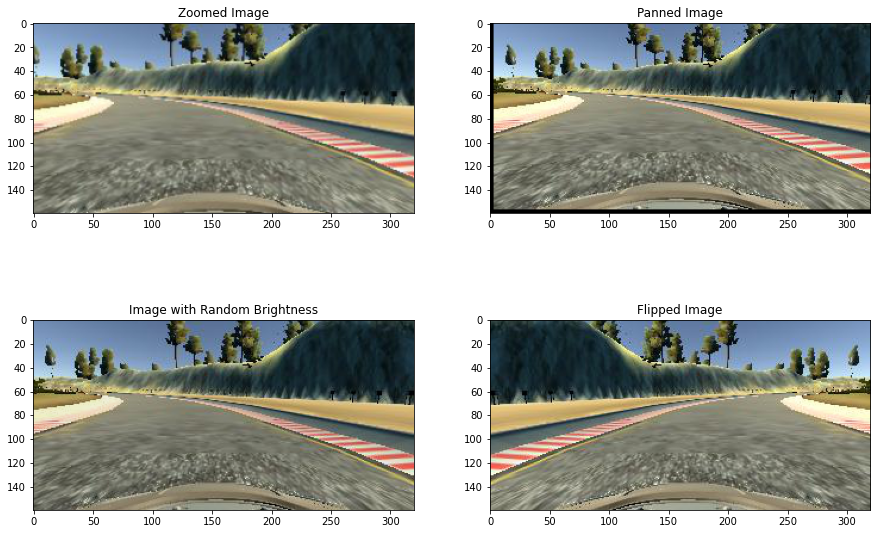

In [20]:
image = image_paths[0]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
panned_image = pan(original_image)
random_image = img_random_brightness(original_image)
flipped_image, s = img_random_flip(original_image, steerings)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(original_image)
ax.set_title('Original Image')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0][0].imshow(zoomed_image)
axes[0][0].set_title('Zoomed Image')

axes[0][1].imshow(panned_image)
axes[0][1].set_title('Panned Image')

axes[1][0].imshow(random_image)
axes[1][0].set_title('Image with Random Brightness')

axes[1][1].imshow(flipped_image)
axes[1][1].set_title('Flipped Image')

In [21]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
    image = zoom(image)
    image = img_random_brightness(image)
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

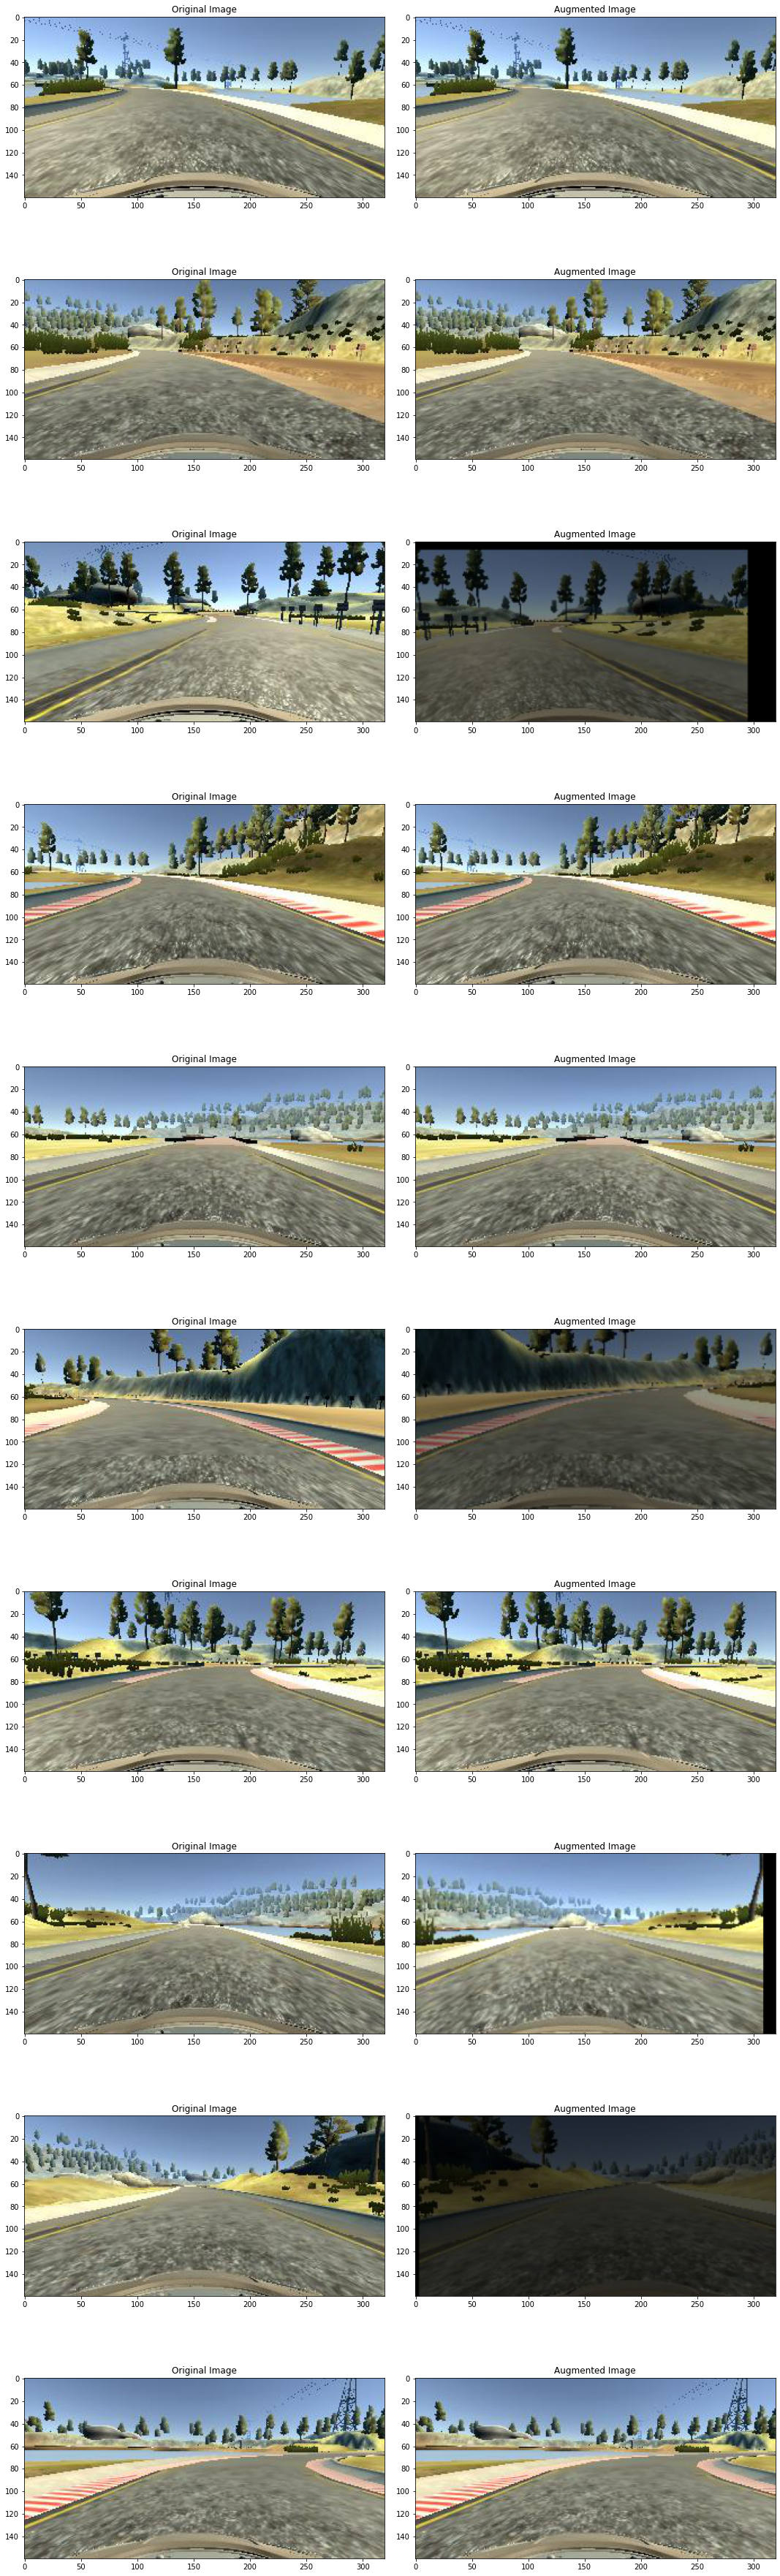

In [22]:
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
for i in range(10):
  randomnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randomnum]
  random_steering = steerings[randomnum]
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axes[i][0].imshow(original_image)
  axes[i][0].set_title('Original Image')

  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title('Augmented Image')

In [29]:
def img_preprocess(img):
  # cut off irrelevant information
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  # cancel noises
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

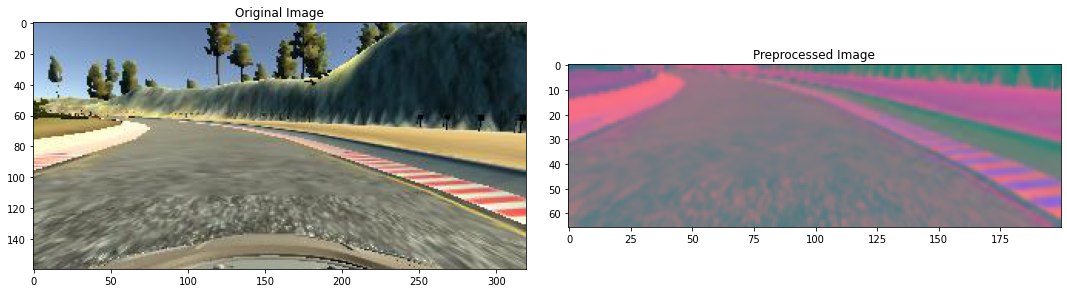

In [30]:
image = image_paths[0] # sample
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [31]:
def batch_generator(image_paths, steering_angle, batch_size, training):
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      if training:
        im, steering = random_augment(image_paths[random_index], steering_angle[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_angle[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

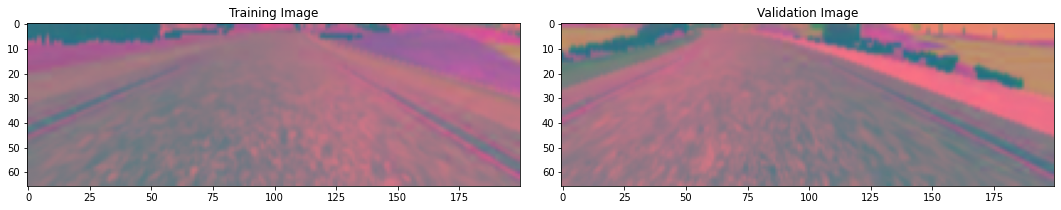

In [32]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, True))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, False))

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Image')
axes[1].imshow(x_valid_gen[0])
axes[1].set_title('Validation Image')

In [41]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Conv2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Conv2D(64, 3, 3, activation='elu'))
  
  model.add(Conv2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [42]:
model = nvidia_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [47]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, True), 
      steps_per_epoch=300, 
      epochs=20, 
      validation_data=batch_generator(X_valid, y_valid, 100, False),
      validation_steps=200,
      verbose=1, 
      shuffle=1)

Epoch 1/20
300/300 [==============================] - 208s 694ms/step - loss: 0.0973 - val_loss: 0.0911
Epoch 2/20
300/300 [==============================] - 203s 676ms/step - loss: 0.0977 - val_loss: 0.0874
Epoch 3/20
300/300 [==============================] - 201s 671ms/step - loss: 0.0979 - val_loss: 0.0941
Epoch 4/20
300/300 [==============================] - 203s 678ms/step - loss: 0.0972 - val_loss: 0.1698
Epoch 5/20
300/300 [==============================] - 203s 677ms/step - loss: 0.0976 - val_loss: 0.0817
Epoch 6/20
300/300 [==============================] - 203s 678ms/step - loss: 0.0967 - val_loss: 0.1420
Epoch 7/20
300/300 [==============================] - 201s 671ms/step - loss: 0.0967 - val_loss: 0.1332
Epoch 8/20
300/300 [==============================] - 200s 667ms/step - loss: 0.0980 - val_loss: 0.1102
Epoch 9/20
300/300 [==============================] - 202s 672ms/step - loss: 0.0957 - val_loss: 0.0918
Epoch 10/20
300/300 [==============================] - 201s 670m

Text(0.5, 0, 'Epoch')

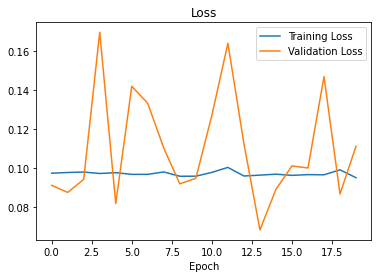

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('steering_model.h5')

from google.colab import files
files.download('steering_model.h5')

# Previous models

In [ ]:
def canny_(image):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, (5,5), 0)
  canny = cv2.Canny(blur, 50, 150)
  return canny
# cv2.imshow('result', gray)
# cv2.waitKey(0)

In [ ]:
def region_of_interest(image):
  height = image.shape[0]
  polygons = np.array([
      [(200, height), (1100, height), (550, 250)]
  ])
  mask = np.zeros_like(image)
  cv2.fillPoly(mask, polygons, 255)
  masked_image = cv2.bitwise_and(image, mask)
  return masked_image

In [ ]:
def display_lines(image, lines):
  line_image = np.zeros_like(image)
  if lines is not None:
    for line in lines:
      x1, y1, x2, y2 = line.reshape(4)
      cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
  return line_image

In [ ]:
def make_coordinates(image, line_parameters):
  slope, intercept = line_parameters
  y1 = image.shape[0]
  y2 = int(y1*(3/5))

  x1 = int((y1 - intercept) / slope)
  x2 = int((y2 - intercept) / slope)
  return np.array([x1, y1, x2, y2])

In [ ]:
def average_slope_intercept(image, lines):
  left_fit = []
  right_fit = []
  for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    parameters = np.polyfit((x1, x2), (y1, y2), 1)
    slope = parameters[0]
    intercept = parameters[1]
    if slope < 0:
      left_fit.append((slope, intercept))
    else:
      right_fit.append((slope, intercept))
  left_fit_average = np.average(left_fit, axis=0)
  right_fit_average = np.average(right_fit, axis=0)
  left_line = make_coordinates(image, left_fit_average)
  right_line = make_coordinates(image, right_fit_average)
  return np.array([left_line, right_line])

In [ ]:
image = cv2.imread('test_image.jpg')
lane_image = np.copy(image)
canny = canny_(lane_image)
cropped_image = region_of_interest(canny)
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)

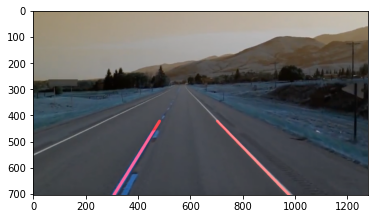

In [ ]:
plt.imshow(combo_image)
plt.show()

In [ ]:
cap = cv2.VideoCapture('test2.mp4')
while(cap.isOpened()):
  _, frame = cap.read()
  canny = canny_(frame)
  cropped_image = region_of_interest(canny)
  lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
  averaged_lines = average_slope_intercept(frame, lines)
  line_image = display_lines(frame, averaged_lines)
  combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
  # plt.imshow(combo_image)
  # plt.show()
  cv2.imshow('result', combo_image)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle

In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(y_val.shape)

(4410,)


In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

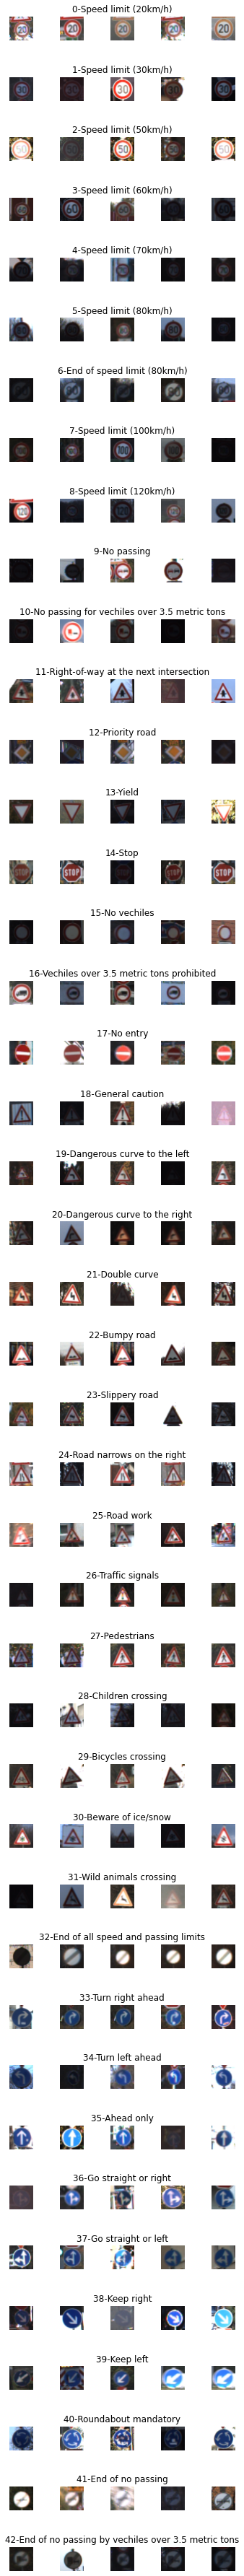

In [ ]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

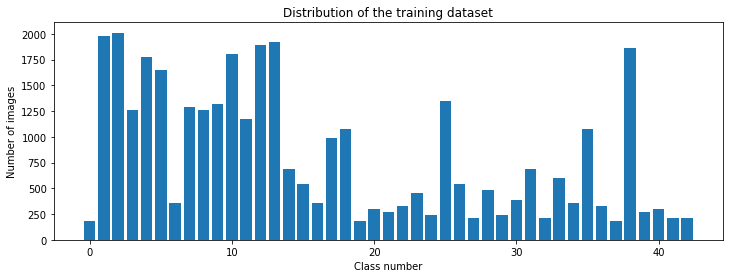

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32)


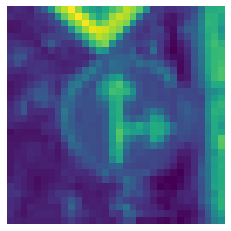

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

(32, 32)


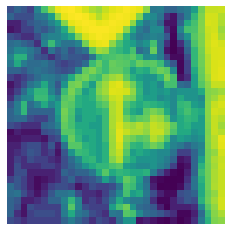

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [ ]:
def preprocessing(img):
  img = equalize(grayscale(img))
  img = img / 255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


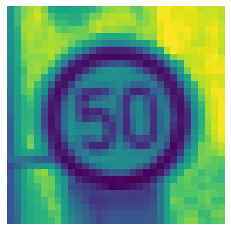

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        shear_range=0.1,
        rotation_range=10)

datagen.fit(X_train)

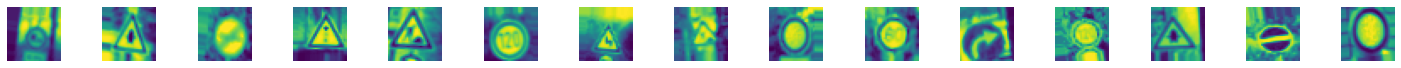

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = leNet_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 48s 24ms/step - loss: 0.8614 - accuracy: 0.7482 - val_loss: 0.0964 - val_accuracy: 0.9712
Epoch 2/10
2000/2000 [==============================] - 42s 21ms/step - loss: 0.2132 - accuracy: 0.9341 - val_loss: 0.0820 - val_accuracy: 0.9753
Epoch 3/10
2000/2000 [==============================] - 42s 21ms/step - loss: 0.1409 - accuracy: 0.9561 - val_loss: 0.0816 - val_accuracy: 0.9821
Epoch 4/10
2000/2000 [==============================] - 42s 21ms/step - loss: 0.1083 - accuracy: 0.9670 - val_loss: 0.0674 - val_accuracy: 0.9846
Epoch 5/10
2000/2000 [==============================] - 42s 21ms/step - loss: 0.0933 - accuracy: 0.9715 - val_loss: 0.0324 - val_accuracy: 0.9918
Epoch 6/10
2000/2000 [==============================] - 41s 21ms/step - loss: 0.0821 - accuracy: 0.9749 - val_loss: 0.0193 - val_accuracy: 0.9937
Epoch 7/10
2000/2000 [==============================] - 41s 21ms/step - loss: 0.0753 - accuracy: 0.9769 - val_loss: 0.0261 -

In [ ]:
data

ClassId                                            SignName
0   0        Speed limit (20km/h)                              
1   1        Speed limit (30km/h)                              
2   2        Speed limit (50km/h)                              
3   3        Speed limit (60km/h)                              
4   4        Speed limit (70km/h)                              
5   5        Speed limit (80km/h)                              
6   6        End of speed limit (80km/h)                       
7   7        Speed limit (100km/h)                             
8   8        Speed limit (120km/h)                             
9   9        No passing                                        
10  10       No passing for vechiles over 3.5 metric tons      
11  11       Right-of-way at the next intersection             
12  12       Priority road                                     
13  13       Yield                                             
14  14       Stop                                              
15  15       No vechiles                                       
16  16       Vechiles over 3.5 metric tons prohibited          
17  17       No entry                                          
18  18       General caution                                   
19  19       Dangerous curve to the left                       
20  20       Dangerous curve to the right                      
21  21       Double curve                                      
22  22       Bumpy road                                        
23  23       Slippery road                                     
24  24       Road narrows on the right                         
25  25       Road work                                         
26  26       Traffic signals                                   
27  27       Pedestrians                                       
28  28       Children crossing                                 
29  29       Bicycles crossing                                 
30  30       Beware of ice/snow                                
31  31       Wild animals crossing                             
32  32       End of all speed and passing limits               
33  33       Turn right ahead                                  
34  34       Turn left ahead                                   
35  35       Ahead only                                        
36  36       Go straight or right                              
37  37       Go straight or left                               
38  38       Keep right                                        
39  39       Keep left                                         
40  40       Roundabout mandatory                              
41  41       End of no passing                                 
42  42       End of no passing by vechiles over 3.5 metric tons